# A Trash Sorting Robot

## Modeling a World State Using Prob

Here the focus is on the dealing with the uncertainty of the type of trash that comes to the robot out of a sample space of = {cardboard, paper, can, scrap metal, bottle}

From the sensors we can get a prob distribution for a given instance.
But before sensors we can use context and knowledge to have prior Prob distributions. 

If we know that given 1000 objects 
- cardboard 200
- paper 300
- can 250
- scrap metal 200
- bottle 50

In [1]:
import gtsam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# VARIABLES = Variables()
# categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]

In [2]:
#VARIABLES = Variables()
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
# Category = VARIABLES.discrete("Category", categories)

Category = 0,5

category_prior = gtsam.DiscreteDistribution(Category, "200/300/250/200/50")
PMF = category_prior.pmf()
print(category_prior.pmf())
print("P('can'): ",category_prior(categories.index("can")))
category_prior

[0.2, 0.3, 0.25, 0.2, 0.05]
P('can'):  0.25


0,value
0,0.2
1,0.3
2,0.25
3,0.2
4,0.05


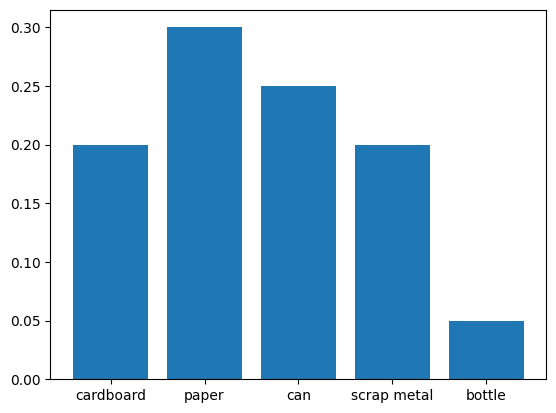

In [3]:
plt.bar(categories,category_prior.pmf())
plt.show()

[0.2  0.5  0.75 0.95 1.  ]


(array([190.,   0., 293.,   0.,   0., 259.,   0., 206.,   0.,  52.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

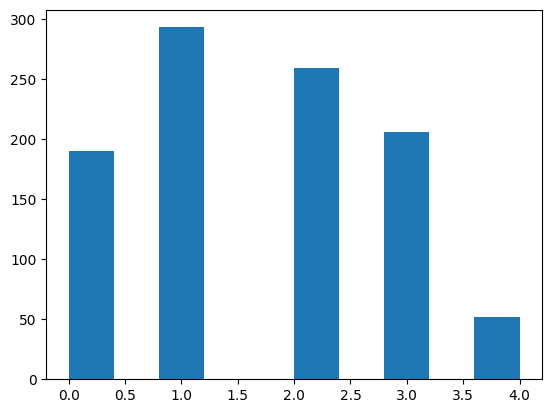

In [4]:
CDF = np.cumsum(PMF)
print(CDF)

## Sampling so that we can simulate (Higher the sample size closer the original PMF)
def sample():
    u = np.random.rand()
    for category in range(5):
        if u<float(CDF[category]):
            return category
        
plt.hist(x = [sample() for i in range(1000)])

(array([184.,   0., 339.,   0.,   0., 239.,   0., 192.,   0.,  46.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

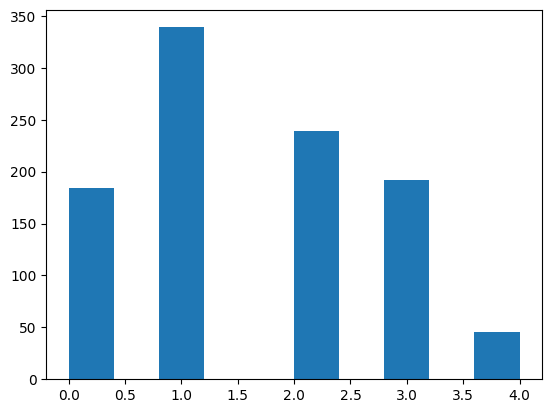

In [5]:

plt.hist(x = [category_prior.sample() for i in range(1000)])

## Actions

The main actions are choosing between the bins or nop


In [6]:
actions = ["glass bin", "metal bin", "paper bin", "nop"]
cost = np.array([[2,2,4,6,0],
                 [1,1,0,0,2],
                 [0,0,5,10,3],
                 [1,1,1,1,1]])
pd.DataFrame(cost, index=actions, columns=categories)

,cardboard,paper,can,scrap metal,bottle
glass bin,2,2,4,6,0
metal bin,1,1,0,0,2
paper bin,0,0,5,10,3
nop,1,1,1,1,1


We can get the expected value for each action  by multiplying the 4x5 cost matrix with 5 x 1 PMF

In [7]:
# This is something i didn't know aparently @ in python is for matrix multiply

cost @ PMF 

array([3.2, 0.6, 3.4, 1. ])

In [8]:
# We can see how sampling would get us closer to these expected values

total_cost = 0
N = 100000000 #3.20002 
N = 1000 #3.246
N = 10000 # 3.22
N = 100 # 3.6
action = 0
for i in range(N):
    category = category_prior.sample()
    total_cost += cost[action, category]
cost_estimate = total_cost/N
print(cost_estimate)

3.0


In [9]:
# CPT for the conductivity given category 
Conductivity = 0,2
pCT = gtsam.DiscreteConditional(Conductivity, [Category], "99/1 99/1 10/90 15/85 95/5")
print(pCT)

Discrete Conditional
 P( 0 | 0 ):
 Choice(0) 
 0 Choice(0) 
 0 0 Leaf 0.99
 0 1 Leaf 0.01
 1 Choice(0) 
 1 0 Leaf 0.99
 1 1 Leaf 0.01
 2 Choice(0) 
 2 0 Leaf  0.1
 2 1 Leaf  0.9
 3 Choice(0) 
 3 0 Leaf 0.15
 3 1 Leaf 0.85
 4 Choice(0) 
 4 0 Leaf 0.95
 4 1 Leaf 0.05




In [26]:
Detection = 0,3
print([Category])
pDT = gtsam.DiscreteConditional(Detection, [Category],"2/88/10 2/20/78 33/33/34 33/33/34 95/2/3")
print(pDT)

[(0, 5)]
Discrete Conditional
 P( 0 | 0 ):
 Choice(0) 
 0 Choice(0) 
 0 0 Leaf 0.02
 0 1 Leaf 0.88
 0 2 Leaf  0.1
 1 Choice(0) 
 1 0 Leaf 0.02
 1 1 Leaf  0.2
 1 2 Leaf 0.78
 2 Choice(0) 
 2 0 Leaf 0.33
 2 1 Leaf 0.33
 2 2 Leaf 0.34
 3 Choice(0) 
 3 0 Leaf 0.33
 3 1 Leaf 0.33
 3 2 Leaf 0.34
 4 Choice(0) 
 4 0 Leaf 0.95
 4 1 Leaf 0.02
 4 2 Leaf 0.03




In [11]:
def Gaussian(x, mu=0.0, sigma=1.0):
    return np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi*sigma**2)

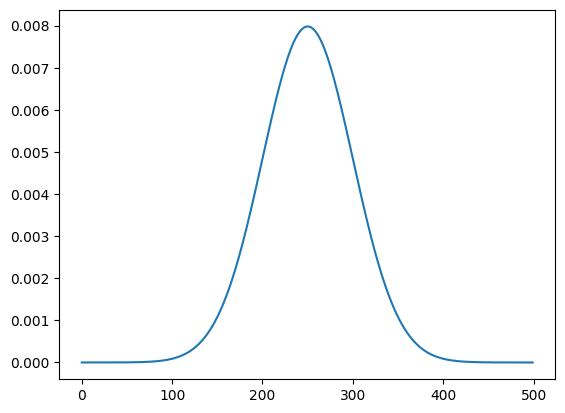

In [12]:
X = np.arange(0, 500)
plt.plot(X,Gaussian(X,mu=250, sigma=50))

In [13]:
pWC = np.array([[20,10],[5,5],[15,5],[150,100],[300,200]])
pWC

array([[ 20,  10],
       [  5,   5],
       [ 15,   5],
       [150, 100],
       [300, 200]])

In [14]:
from ipywidgets import interact
@interact(Category=categories)
def plot_weight_density(Category="can"):
    index = categories.index(Category)
    display(plt.plot(X, Gaussian(X, *pWC[index])))

interactive(children=(Dropdown(description='Category', index=2, options=('cardboard', 'paper', 'can', 'scrap m…

In [15]:
# Sampling from category 
category = category_prior.sample()
print("category=",category, categories[category])

# Sample from the discrete sensors
values = gtsam.DiscreteValues()
print(values,Category[0])
values[Category[0]] = category
print(values)
print("conductivity = ",pCT.sample(values))
print("detection = ",pDT.sample(values))

# sampling from continous (Gaussian)
print("weight = ",np.random.normal(*pWC[category]))

category= 3 scrap metal
DiscreteValues{} 0
DiscreteValues{0: 3}
conductivity =  1
detection =  1
weight =  170.60984223931425


In [16]:
# Sample from state, then from all three sensors:
def sample():
    category = category_prior.sample()
    values = gtsam.DiscreteValues()
    values[Category[0]] = category
    conductivity = pCT.sample(category)
    detection = pDT.sample(category)
    weight = np.random.normal(*pWC[category])
    return category, conductivity, detection, weight

In [17]:
for _ in range(10):
    print(sample())

(1, 0, 2, 12.048236888819286)
(4, 0, 0, 225.14933094817513)
(3, 1, 0, 113.69852343232436)
(3, 0, 0, 283.3105343544791)
(3, 0, 2, 72.77325072356524)
(2, 1, 2, 7.561486646442951)
(3, 0, 1, 50.65260587853302)
(2, 1, 2, 19.697809290841647)
(1, 0, 2, 13.107511503824922)
(2, 1, 1, 18.302152508639953)


In [18]:
# If the given weight is 50g what is the most likely 
for index, category in enumerate(categories):
    mu, sigma = pWC[index]
    print(f"{category:12}:{Gaussian(50, mu, sigma):.5f}")

cardboard   :0.00044
paper       :0.00000
can         :0.00000
scrap metal :0.00242
bottle      :0.00091


<BarContainer object of 5 artists>

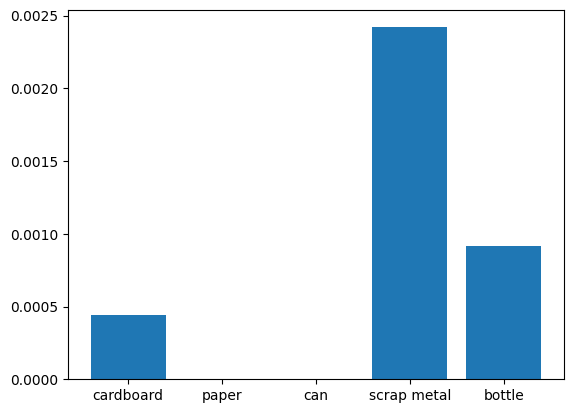

In [19]:
# putting to the above as a function
def likelihood_given_weight(weight):
    return np.array([Gaussian(weight, *pWC[index]) for index in range(5)])
L50 = likelihood_given_weight(weight=50)
plt.bar(categories,L50)

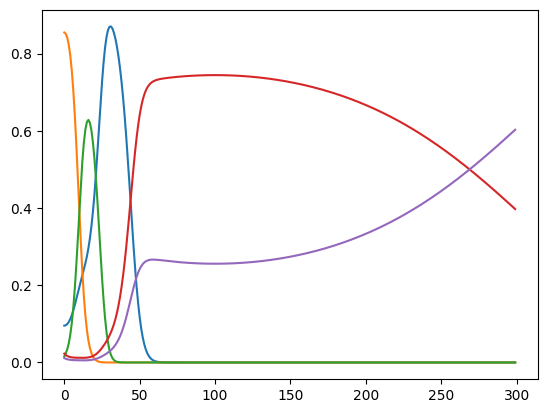

In [20]:
def normalized(x):
    Lx = likelihood_given_weight(x)
    return Lx/np.sum(Lx)
X = np.arange(0.0,300)
Y = np.array([normalized(x) for x in X])

df = pd.DataFrame(data=Y, index=X, columns=categories, )
plt.plot(df, )

In [21]:
# Likelihood function for weight
weight_50_factor = gtsam.DecisionTreeFactor(
    Category, likelihood_given_weight(50))
weight_50_factor

0,value
0,0.000443185
1,2.05595e-19
2,1.82694e-12
3,0.00241971
4,0.000913245


In [48]:
#For discrete case in picking likelihood using GTSAM
detector_outcomes = ["bottle", "cardboard", "paper"]
index = detector_outcomes.index("cardboard")  # 1 is theindex for "cardboard"
print(pDT)
for i in pDT.enumerate():
    print(i)
# detected_cardboard_factor = [i for i in pDT.enumerate]
# detected_cardboard_factor = pDT.likelihood(index)
# detected_cardboard_factor

Discrete Conditional
 P( 0 | 0 ):
 Choice(0) 
 0 Choice(0) 
 0 0 Leaf 0.02
 0 1 Leaf 0.88
 0 2 Leaf  0.1
 1 Choice(0) 
 1 0 Leaf 0.02
 1 1 Leaf  0.2
 1 2 Leaf 0.78
 2 Choice(0) 
 2 0 Leaf 0.33
 2 1 Leaf 0.33
 2 2 Leaf 0.34
 3 Choice(0) 
 3 0 Leaf 0.33
 3 1 Leaf 0.33
 3 2 Leaf 0.34
 4 Choice(0) 
 4 0 Leaf 0.95
 4 1 Leaf 0.02
 4 2 Leaf 0.03


(DiscreteValues{0: 0}, 0.02)
(DiscreteValues{0: 1}, 0.2)
(DiscreteValues{0: 2}, 0.34)


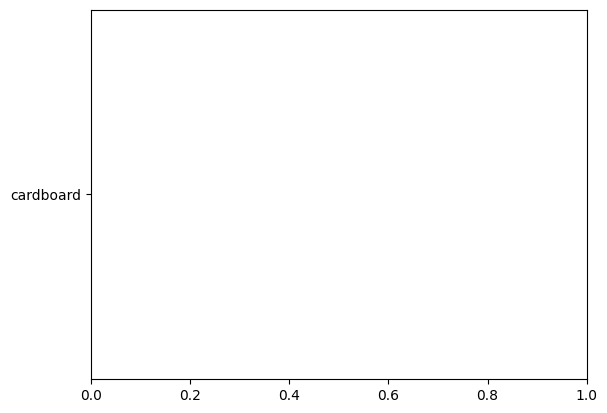

interactive(children=(Dropdown(description='detection', options=('bottle', 'cardboard', 'paper'), value='bottl…

In [35]:
@interact(detection=detector_outcomes)
def show_likelihood(detection="bottle"):
    index = detector_outcomes.index(detection)
    print(index)
    L_index = [v for (k,v) in pDT.likelihood(index).enumerate()]
    print(L_index,categories)
    plt.bar(L_index, categories)